In [ ]:
import pandas as pd
import numpy as np
import lightkurve as lk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

print(f"Torch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Suppress warnings
warnings.filterwarnings("ignore")

#  CONFIGURATION 
SAVE_DIR = "./saved_lightcurves"
os.makedirs(SAVE_DIR, exist_ok=True)
FILE_KOI = "DATA/q1_q8_koi_2025.02.03_04.12.15.csv"



Torch: 2.5.1+cu121
CUDA: True
Using device: cuda


In [14]:
#  1. LOAD METADATA 
print("1. Loading metadata...")
try:
    df = pd.read_csv(FILE_KOI, comment='#')
except FileNotFoundError:
    print(f"ERROR: File {FILE_KOI} not found.")
    df = pd.DataFrame()

if not df.empty:
    valid_dispositions = ['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE']
    df = df[df['koi_disposition'].isin(valid_dispositions)]
    df['target'] = df['koi_disposition'].apply(lambda x: 0 if x == 'FALSE POSITIVE' else 1)
    df['kepid'] = df['kepid'].fillna(0).astype(int)

    # USE FULL DATASET
    # We shuffle the dataset to ensure randomness
    df_sample = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"Targets ready: {len(df_sample)} stars to process.")
    print("Note: This is a large run. The first execution will take time to download data.")

1. Loading metadata...
Targets ready: 3286 stars to process.
Note: This is a large run. The first execution will take time to download data.


In [15]:
#  2. ROBUST DATA PROCESSING FUNCTION 
def get_light_curve_data(kepid, period, t0, n_bins=1024):
    """
    Downloads, folds, and interpolates light curve.
    Includes safety checks for file types (TPF vs LightCurve) 
    and forces conversion to standard Numpy arrays.
    """
    filename = os.path.join(SAVE_DIR, f"kic_{kepid}.npy")
    
    # Check cache
    if os.path.exists(filename):
        return np.load(filename)
    
    try:
        # Search for any available data
        search_result = lk.search_lightcurve(f"KIC {kepid}", author="Kepler")
        
        if len(search_result) == 0:
            return None
            
        # Download the first available result
        lc_object = search_result[0].download()
        
        #  TYPE SAFETY CHECK 
        # Sometimes Lightkurve returns a TargetPixelFile instead of a LightCurve.
        # If so, convert it.
        if hasattr(lc_object, 'to_lightcurve'):
            lc = lc_object.to_lightcurve()
        else:
            lc = lc_object
            
        # Check if the object actually has the normalize method
        if not hasattr(lc, 'normalize'):
            return None

        # Normalize and remove NaNs
        lc = lc.normalize().remove_nans()
        
        # FOLDING
        folded_lc = lc.fold(period=period, epoch_time=t0)
        
        #  CRITICAL FIX: Cast to standard Numpy Array 
        # This removes the 'MaskedNDArray' type that causes numpy.save errors
        phase = np.array(folded_lc.time.value, dtype=np.float64)
        flux = np.array(folded_lc.flux.value, dtype=np.float64)
        
        #  FAST INTERPOLATION 
        # 1. Sort by phase (Folding can scramble order)
        sort_idx = np.argsort(phase)
        phase_sorted = phase[sort_idx]
        flux_sorted = flux[sort_idx]
        
        # 2. Create a uniform grid of 1024 points
        uniform_phase = np.linspace(phase_sorted[0], phase_sorted[-1], n_bins)
        
        # 3. Interpolate flux onto the new grid
        binned_flux = np.interp(uniform_phase, phase_sorted, flux_sorted)
        
        # 4. Handle NaNs
        binned_flux = np.nan_to_num(binned_flux, nan=1.0)
        
        # Save to disk
        np.save(filename, binned_flux)
        
        return binned_flux
        
    except Exception as e:
        # Uncomment the line below to debug specific star errors
        # print(f"  [Error KIC {kepid}]: {e}")
        return None

In [16]:
#  3. DATASET PREPARATION 
X_data = []
y_data = []

print("\n2. Downloading and processing data...")

if not df.empty:
    for index, row in df_sample.iterrows():
        kepid = row['kepid']
        period = row['koi_period']
        t0 = row['koi_time0bk']
        label = row['target']
        
        flux = get_light_curve_data(kepid, period, t0)
        
        if flux is not None and len(flux) == 1024:
            X_data.append(flux)
            y_data.append(label)
            
            if len(X_data) % 10 == 0:
                print(f"  -> Processed {len(X_data)} / {len(df_sample)}...")

    if len(X_data) > 0:
        X = np.array(X_data).reshape(len(X_data), 1, 1024)
        y = np.array(y_data)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        print(f"\nData successfully prepared! Training Set Size: {len(X_train)}")
    else:
        print("No valid data collected.")
        X_train = []


2. Downloading and processing data...
  -> Processed 10 / 3286...
  -> Processed 20 / 3286...
  -> Processed 30 / 3286...
  -> Processed 40 / 3286...
  -> Processed 50 / 3286...
  -> Processed 60 / 3286...
  -> Processed 70 / 3286...
  -> Processed 80 / 3286...
  -> Processed 90 / 3286...
  -> Processed 100 / 3286...
  -> Processed 110 / 3286...
  -> Processed 120 / 3286...
  -> Processed 130 / 3286...
  -> Processed 140 / 3286...
  -> Processed 150 / 3286...
  -> Processed 160 / 3286...
  -> Processed 170 / 3286...
  -> Processed 180 / 3286...
  -> Processed 190 / 3286...
  -> Processed 200 / 3286...
  -> Processed 210 / 3286...
  -> Processed 220 / 3286...
  -> Processed 230 / 3286...
  -> Processed 240 / 3286...
  -> Processed 250 / 3286...
  -> Processed 260 / 3286...
  -> Processed 270 / 3286...
  -> Processed 280 / 3286...
  -> Processed 290 / 3286...
  -> Processed 300 / 3286...
  -> Processed 310 / 3286...
  -> Processed 320 / 3286...
  -> Processed 330 / 3286...
  -> Processe

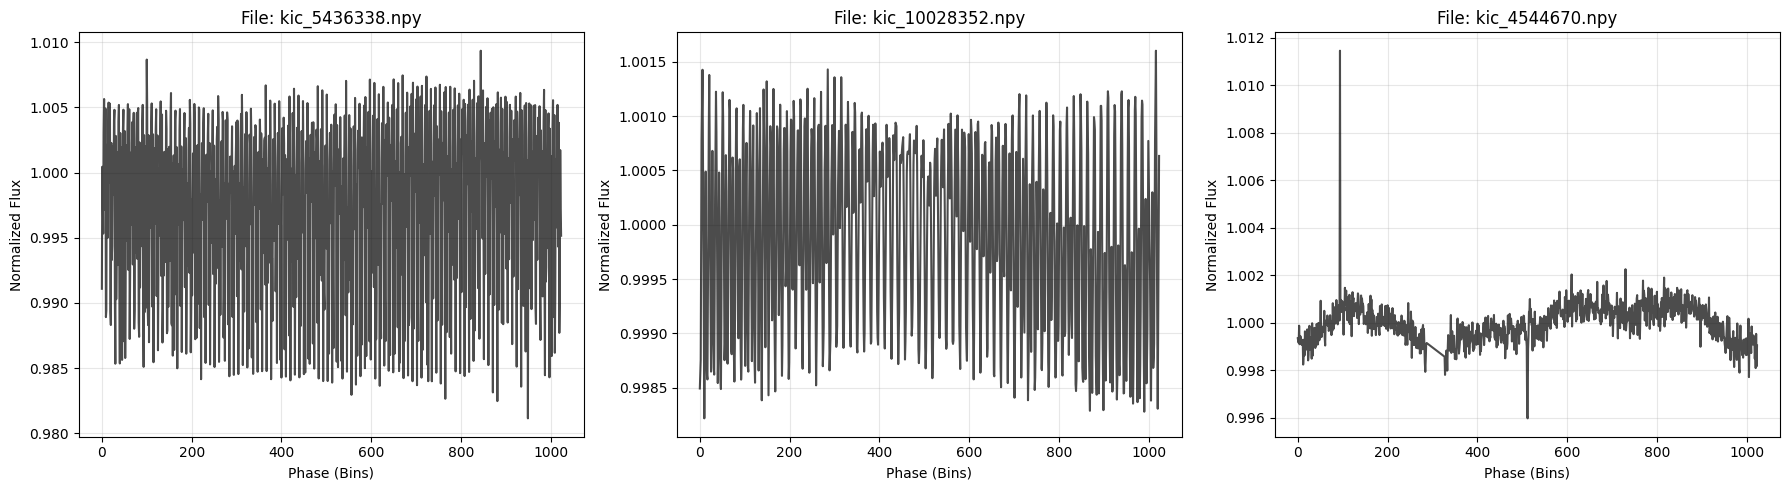

Displaying 3 random light curves out of 2580 available.


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random

# Directory containing the generated .npy files
SAVE_DIR = "./saved_lightcurves"

# Get a list of all saved files
if os.path.exists(SAVE_DIR):
    all_files = [f for f in os.listdir(SAVE_DIR) if f.endswith('.npy')]
else:
    all_files = []

# Check if we have enough files
if len(all_files) >= 3:
    # Select 3 random files
    selected_files = random.sample(all_files, 3)
    
    # Create the figure
    plt.figure(figsize=(18, 5))
    
    for i, filename in enumerate(selected_files):
        # Load the data (numpy array of size 1024)
        flux = np.load(os.path.join(SAVE_DIR, filename))
        
        # Plot the graph
        plt.subplot(1, 3, i+1)  # 1 row, 3 columns, index i+1
        plt.plot(flux, color='black', alpha=0.7)
        plt.title(f"File: {filename}")
        plt.xlabel("Phase (Bins)")
        plt.ylabel("Normalized Flux")
        plt.grid(True, alpha=0.3)
        
    plt.tight_layout()
    plt.show()
    
    print(f"Displaying 3 random light curves out of {len(all_files)} available.")
else:
    print(f"Not enough data to display 3 images (only {len(all_files)} files found).")

In [ ]:
class ExoplanetCNN_Improved(nn.Module):
    def __init__(self):
        super(ExoplanetCNN_Improved, self).__init__()
        
        # Feature Extraction (Convolutional Layers)
        self.features = nn.Sequential(
            # Layer 1
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Layer 2
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Layer 3
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Layer 4
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            
            # Global Pooling:
            nn.AdaptiveAvgPool1d(1) 
        )
        
        # Classification Layers (Fully Connected)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5), # Prevents overfitting
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1) # Single output for Binary Classification
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [19]:
# Initialize Model
model = ExoplanetCNN_Improved().to(device)

# Define Hyperparameters
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Handle Class Imbalance (Weighting the positive class)
# Assuming 0 = Non-Planet, 1 = Planet
num_pos = np.sum(y_train == 1)
num_neg = np.sum(y_train == 0)
pos_weight_value = num_neg / num_pos if num_pos > 0 else 1.0
pos_weight_tensor = torch.tensor([pos_weight_value]).to(device)

# Loss Function (Binary Cross Entropy with Logits)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

#  SHOW MODEL SUMMARY 
print("\n Model Architecture Summary ")
# Create a dummy input to calculate shapes
dummy_input = (BATCH_SIZE, 1, X_train.shape[-1])
summary(model, input_size=dummy_input, col_names=["input_size", "output_size", "num_params"])


 Model Architecture Summary 


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ExoplanetCNN_Improved                    [64, 1, 1024]             [64, 1]                   --
├─Sequential: 1-1                        [64, 1, 1024]             [64, 256, 1]              --
│    └─Conv1d: 2-1                       [64, 1, 1024]             [64, 32, 1024]            192
│    └─BatchNorm1d: 2-2                  [64, 32, 1024]            [64, 32, 1024]            64
│    └─ReLU: 2-3                         [64, 32, 1024]            [64, 32, 1024]            --
│    └─MaxPool1d: 2-4                    [64, 32, 1024]            [64, 32, 512]             --
│    └─Conv1d: 2-5                       [64, 32, 512]             [64, 64, 512]             10,304
│    └─BatchNorm1d: 2-6                  [64, 64, 512]             [64, 64, 512]             128
│    └─ReLU: 2-7                         [64, 64, 512]             [64, 64, 512]             --
│    └─MaxPool1d: 2-8        

In [20]:
from torch.utils.data import DataLoader, TensorDataset
import torch

# 1. On définit la taille du batch (comme discuté)
BATCH_SIZE = 64

# 2. Vérification de sécurité : Est-ce que vos données brutes existent ?
if 'X_train' not in locals():
    print("ERREUR : X_train n'existe pas !")
    print("-> Veuillez remonter tout en haut et relancer le chargement des données (train_test_split).")
else:
    print(f"Préparation des DataLoaders avec Batch Size = {BATCH_SIZE}...")

    # 3. Conversion Numpy -> Tensor PyTorch
    # On s'assure que le format est (N, 1, Longueur)
    if X_train.ndim == 2:
        X_train_tensor = torch.tensor(X_train).float().unsqueeze(1)
        X_test_tensor = torch.tensor(X_test).float().unsqueeze(1)
    else:
        X_train_tensor = torch.tensor(X_train).float()
        X_test_tensor = torch.tensor(X_test).float()

    y_train_tensor = torch.tensor(y_train).float().unsqueeze(1)
    y_test_tensor = torch.tensor(y_test).float().unsqueeze(1)

    # 4. Création des Datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    # 5. Création des DataLoaders (C'est ça qui manquait !)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print("Succès ! 'train_loader' et 'test_loader' sont créés.")
    print(f"Nombre de batchs par époque : {len(train_loader)}")

Préparation des DataLoaders avec Batch Size = 64...
Succès ! 'train_loader' et 'test_loader' sont créés.
Nombre de batchs par époque : 42


In [21]:
import torch
import copy

#  CONFIGURATION OPTIMISÉE 
EPOCHS = 50
patience = 10  # Si pas d'amélioration pendant 10 époques, on arrête ou on réduit le LR

# On reprend un LR un peu plus haut pour démarrer, le scheduler le baissera
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# SCHEDULER : Divise le LR par 10 si la validation ne s'améliore pas pendant 5 époques
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

train_losses = []
val_losses = []

print(f"\nStarting Smart Training for {EPOCHS} epochs...")

for epoch in range(EPOCHS):
    #  Training 
    model.train()
    running_train_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    #  Validation 
    model.eval()
    running_val_loss = 0.0
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            running_val_loss += loss.item()
            
    avg_val_loss = running_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    
    #  SCHEDULER STEP 
    # On dit au scheduler : "Tiens, voilà la loss de validation, adapte-toi"
    scheduler.step(avg_val_loss)

    #  SAUVEGARDE DU MEILLEUR MODÈLE 
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_model.pth') # Sauvegarde sur le disque
        print(f"Epoch {epoch+1} : New Best Model! (Val Loss: {avg_val_loss:.4f})")
    
    if (epoch + 1) % 5 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{EPOCHS}] | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f} | LR: {current_lr:.1e}")

print("Training Complete.")

#  CHARGEMENT DU MEILLEUR MODÈLE POUR L'ÉVALUATION 
print(f"\nLoading best model from epoch with loss {best_val_loss:.4f}...")
model.load_state_dict(best_model_wts)


Starting Smart Training for 50 epochs...
Epoch 1 : New Best Model! (Val Loss: 0.2909)
Epoch 5 : New Best Model! (Val Loss: 0.2906)
Epoch [5/50] | Train: 0.2948 | Val: 0.2906 | LR: 1.0e-03
Epoch [10/50] | Train: 0.2880 | Val: 0.2912 | LR: 1.0e-03
Epoch 12 : New Best Model! (Val Loss: 0.2886)
Epoch [15/50] | Train: 0.2931 | Val: 0.2892 | LR: 1.0e-04
Epoch [20/50] | Train: 0.2913 | Val: 0.2889 | LR: 1.0e-05
Epoch [25/50] | Train: 0.2878 | Val: 0.2887 | LR: 1.0e-06
Epoch 30 : New Best Model! (Val Loss: 0.2885)
Epoch [30/50] | Train: 0.2886 | Val: 0.2885 | LR: 1.0e-06
Epoch 33 : New Best Model! (Val Loss: 0.2883)
Epoch [35/50] | Train: 0.2882 | Val: 0.2887 | LR: 1.0e-06
Epoch [40/50] | Train: 0.2876 | Val: 0.2892 | LR: 1.0e-07
Epoch [45/50] | Train: 0.2853 | Val: 0.2886 | LR: 1.0e-08
Epoch [50/50] | Train: 0.2896 | Val: 0.2887 | LR: 1.0e-08
Training Complete.

Loading best model from epoch with loss 0.2883...


<All keys matched successfully>

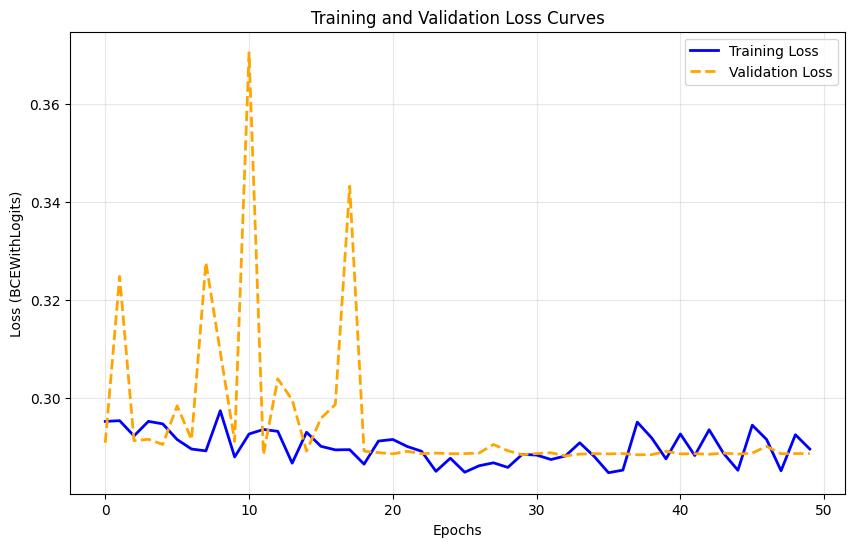

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2, linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss (BCEWithLogits)')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Running final evaluation on Test Set...


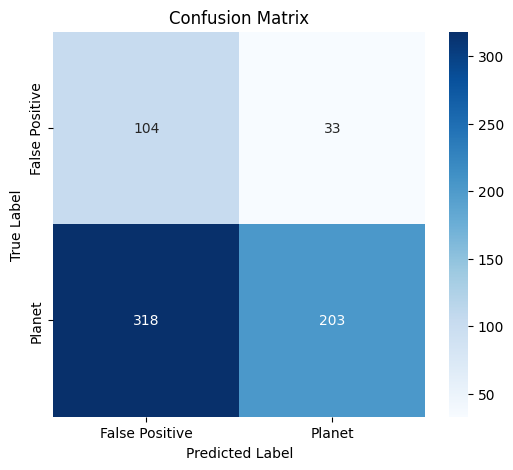


 Detailed Classification Report 
                precision    recall  f1-score   support

False Positive       0.25      0.76      0.37       137
        Planet       0.86      0.39      0.54       521

      accuracy                           0.47       658
     macro avg       0.55      0.57      0.45       658
  weighted avg       0.73      0.47      0.50       658



In [26]:
model.eval()
y_true_list = []
y_pred_list = []

print("Running final evaluation on Test Set...")

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        
        # Apply Sigmoid to get probability, then round to get 0 or 1
        predicted = torch.round(torch.sigmoid(outputs))
        
        # Move back to CPU for metrics
        y_true_list.extend(batch_y.cpu().numpy().flatten())
        y_pred_list.extend(predicted.cpu().numpy().flatten())

# Confusion Matrix
cm = confusion_matrix(y_true_list, y_pred_list)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['False Positive', 'Planet'], 
            yticklabels=['False Positive', 'Planet'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n Detailed Classification Report ")
print(classification_report(y_true_list, y_pred_list, target_names=['False Positive', 'Planet'], zero_division=0))

Calcul des probabilités...

 RÉSULTAT OPTIMAL 
Meilleur seuil trouvé : 0.4593
F1-Score correspondant : 0.8849

 Nouvelle Performance avec ce seuil 
                precision    recall  f1-score   support

False Positive       0.67      0.03      0.06       137
        Planet       0.80      1.00      0.88       521

      accuracy                           0.79       658
     macro avg       0.73      0.51      0.47       658
  weighted avg       0.77      0.79      0.71       658



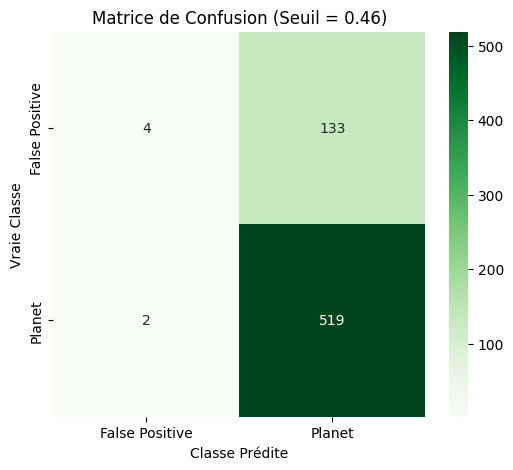

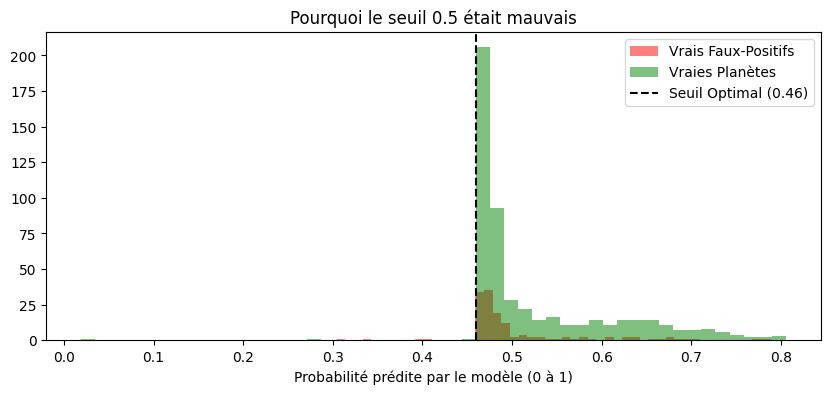

In [24]:
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, auc

model.eval()
y_true = []
y_probs = []

# 1. Récupérer les probabilités brutes (pas les 0 ou 1, mais les 0.45, 0.89...)
print("Calcul des probabilités...")
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        probs = torch.sigmoid(outputs) # On transforme les logits en % (0 à 1)
        
        y_true.extend(batch_y.cpu().numpy().flatten())
        y_probs.extend(probs.cpu().numpy().flatten())

y_true = np.array(y_true)
y_probs = np.array(y_probs)

# 2. Trouver le meilleur seuil (Threshold)
precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

print(f"\n RÉSULTAT OPTIMAL ")
print(f"Meilleur seuil trouvé : {best_threshold:.4f}")
print(f"F1-Score correspondant : {f1_scores[best_threshold_index]:.4f}")

# 3. Appliquer ce nouveau seuil
y_pred_new = (y_probs >= best_threshold).astype(int)

# 4. Afficher la nouvelle matrice
print("\n Nouvelle Performance avec ce seuil ")
cm = confusion_matrix(y_true, y_pred_new)
print(classification_report(y_true, y_pred_new, target_names=['False Positive', 'Planet']))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['False Positive', 'Planet'], 
            yticklabels=['False Positive', 'Planet'])
plt.title(f'Matrice de Confusion (Seuil = {best_threshold:.2f})')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.show()

# 5. Voir la distribution des prédictions
plt.figure(figsize=(10, 4))
plt.hist(y_probs[y_true==0], bins=50, alpha=0.5, label='Vrais Faux-Positifs', color='red')
plt.hist(y_probs[y_true==1], bins=50, alpha=0.5, label='Vraies Planètes', color='green')
plt.axvline(best_threshold, color='black', linestyle='--', label=f'Seuil Optimal ({best_threshold:.2f})')
plt.xlabel('Probabilité prédite par le modèle (0 à 1)')
plt.legend()
plt.title("Pourquoi le seuil 0.5 était mauvais")
plt.show()
